In [1]:
import pandas as pd
import pandasql as ps
import pyodbc
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from keras.layers import GlobalMaxPool1D, Conv1D, Dropout, GRU, Flatten, MaxPooling1D
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [2]:
#Grab data from a database

def getData(Server, UID, PWD, Database, query):    
    
    #create a SQL connection based on the given server and database
    sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                              'SERVER='+Server+';' 
                              'UID='+UID+';'
                              'PWD='+PWD+';'
                              'DATABASE='+Database+';' )
    
    #return the data from the given Query and SQL connection,
    return pd.read_sql(query, sql_conn)

In [3]:
#establish my server and corresponding database to pull data from
server ='GSDEMO2HOST'
database = 'MClinical'
UID = 'gsanalytics'
PWD = 'G3st@lt'


#CREATE CARTESIAN PRODUCT OF THE 4 PARAMETERS, APPLY OUR ALGORITHM TO THE CARTESIAN PRODUCT AND TEST
query ="select input.locationName, input.fillerOrderStatusCd, input.scheduledGroups, input.subSpecialtyCd, CASE WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') = '*GYP' AND input.locationName LIKE '%SPOKANE%' AND input.scheduledGroups = '1' AND input.fillerOrderStatusCd LIKE '%F%' THEN 1 WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') NOT LIKE '*GYP' AND input.locationName LIKE '%SPOKANE%' AND input.scheduledGroups = '3' THEN 2 WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND input.locationName LIKE '%SPOKANE%' THEN 3 WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') LIKE '*GP' AND input.locationName LIKE '%BELLEVUE%' AND input.scheduledGroups = '3' AND input.fillerOrderStatusCd LIKE '%F%' THEN 4 WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND input.locationName LIKE '%BELLEVUE%' AND input.scheduledGroups = '1' AND input.fillerOrderStatusCd LIKE '%C%' THEN 5 WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND input.locationName LIKE '%BELLEVUE%' AND input.scheduledGroups = '1' AND input.fillerOrderStatusCd LIKE '%F%' THEN 6 WHEN input.locationName LIKE '%BELLEVUE%' THEN 7 WHEN input.locationName LIKE '%SPOKANE%' THEN 8 WHEN input.scheduledGroups = '1' THEN 9 WHEN input.scheduledGroups = '2' OR input.scheduledGroups = '3' OR input.scheduledGroups = '4' THEN 10 WHEN input.scheduledGroups = '5' OR input.scheduledGroups = '6' OR input.scheduledGroups = '7' OR input.scheduledGroups = '8' THEN 11 ELSE 12 END as bucketName from ( select fo.locationName, status.fillerOrderStatusCd, scheduled.scheduledGroups, ps.subSpecialtyCd from ( SELECT DISTINCT ISNULL( ProcedureStep.subSpecialtyCd, 'UNKNOWN' ) as subSpecialtyCd FROM ProcedureStep ) as ps, ( SELECT DISTINCT ISNULL(PL.locationName, 'UNKNOWN') as locationName FROM FillerOrder LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey ) as fo, ( SELECT DISTINCT FillerOrder.fillerOrderStatusCd FROM FillerOrder ) as status, ( select distinct fo.scheduledGroups as scheduledGroups from ( select case when DATEDIFF(DAY, scheduled, GETDATE()) <= 465 then 1 when DATEDIFF(DAY, scheduled, GETDATE()) <= 562 then 2 when DATEDIFF(DAY, scheduled, GETDATE()) <= 664 then 3 when DATEDIFF(DAY, scheduled, GETDATE()) <= 762 then 4 when DATEDIFF(DAY, scheduled, GETDATE()) <= 860 then 5 when DATEDIFF(DAY, scheduled, GETDATE()) <= 955 then 6 when DATEDIFF(DAY, scheduled, GETDATE()) <= 1056 then 7 when DATEDIFF(DAY, scheduled, GETDATE()) <= 1153 then 8 when DATEDIFF(DAY, scheduled, GETDATE()) <= 1247 then 9 else 10 end as scheduledGroups from fillerorder ) as fo ) as Scheduled ) as input order by bucketName"
original = getData(server, UID, PWD, database,query)
data = original.copy()


#grab all the distinct subspecialtys. replace null with unknown
query ="SELECT DISTINCT ISNULL(ProcedureStep.subSpecialtyCd, 'UNKNOWN') as subSpecialtyCd FROM ProcedureStep"
subSpecialtyCd = getData(server, UID, PWD, database, query)

#grab all the distinct locationNames. replace null with unknown
query ="SELECT DISTINCT ISNULL(PL.locationName, 'UNKNOWN') as locationName FROM FillerOrder LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey"
locationNameCd = getData(server, UID, PWD, database, query)

#grab all the distinct Status, replace null with unknown
query ="SELECT DISTINCT FillerOrder.fillerOrderStatusCd FROM FillerOrder"
fillerOrderStatusCd = getData(server, UID, PWD, database, query)

#grab all the distinct date groups, since i know there is only 10...
scheduledGroups = np.arange(1,11)

#Used to map a bucketName to a bucketNum, along with mapping to a integer from 0-11
bucketNumCd = np.arange(1,13)

In [4]:
#for all subspecialtys in data, map the string value of the subspecialty to its corresponding
#index value in subSpecialtyCd.
#this is used to map the subspecialty to a integer for our model to take as an input
data['subSpecialtyCd'] = data.subSpecialtyCd.apply(lambda x: np.where(subSpecialtyCd.values == x)[0][0])

#for all status in data, map the string value of the status to its corresponding
#index value in fillerOrderStatusCd.
#this is used to map the status to a integer for our model to take as an input
data['fillerOrderStatusCd'] = data.fillerOrderStatusCd.apply(lambda x: np.where(fillerOrderStatusCd.values == x)[0][0])

#for all locationName in data, map the string value of the locationName to its corresponding
#index value in locationNameCd.
#this is used to map the locationNameCd to a integer for our model to take as an input
data['locationName'] = data.locationName.apply(lambda x: np.where(locationNameCd.values == x)[0][0])

#for all locationName in data, map the string value of the locationName to its corresponding
#index value in locationNameCd.
#this is used to map the locationNameCd to a integer for our model to take as an input
data['scheduledGroups'] = data.scheduledGroups.apply(lambda x: np.where(scheduledGroups == x)[0][0])

#for all bucketName in data, map the string value of the bucketName to its corresponding
#index value in bucketNumCd.
#this is used to map the bucketNumCd to a integer for our model to compare its output against
data['bucketName'] = data.bucketName.apply(lambda x: np.where(bucketNumCd == x)[0][0])

In [5]:
data

,locationName,fillerOrderStatusCd,scheduledGroups,subSpecialtyCd,bucketName
0,1,3,0,7,0
1,1,3,2,6,1
2,1,3,2,9,1
3,1,4,2,18,1
4,1,4,2,16,1
5,1,4,2,12,1
6,1,4,2,8,1
7,1,4,2,1,1
8,1,4,2,13,1
9,1,4,2,14,1


In [6]:
#create the training input set based on the three params
x = data[['subSpecialtyCd', 'fillerOrderStatusCd', 'locationName', 'scheduledGroups' ]]

#create the training labels set
y = data[['bucketName']]

In [7]:
x.shape

(45600, 4)

In [8]:
def create_model(max_words, maxlen):
    #keras default model
    model = Sequential()
    
    #add an embedding layer with the input dim and input length
    model.add(Embedding(input_dim = max_words, input_length=maxlen, output_dim = 50))
    
    #add a bidirectional LSTM layer with 32 units
    model.add(Bidirectional(LSTM(units =32)))
    
    # create a dense output layer with the units = len(bucketNumCd)
    model.add(Dense(12, activation='softmax'))
    
    #print the summary
    model.summary()
    
    return model

In [9]:
#create the model, 
#we define the max_words to be the sum of the lengths of 
#subSpecialtyCd, locationNameCd, and fillerOrderStatusCd

#we define the max_len to be the total number of params we pass into the model
# so in our case 3.
model = create_model(65, 4)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 50)             3250      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                21248     
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 25,278
Trainable params: 25,278
Non-trainable params: 0
_________________________________________________________________


In [10]:
#train the model
def train_model(model, x_train, y_train, epochs, batchsize, max_words, max_len):
    #compile the model
    #optimizer -> rmsprop (standard)
    #loss -> sparse categorical crossentropy (because we have a  multiclassification problem)
    #meteric -> accuracy
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc']) 
    #save the history from the model
    #set the paramiters
    #fit the model
    
    history = model.fit(x_train, 
                        y_train,
                        epochs=epochs,
                        batch_size=batchsize,
                        validation_split=0)
    return history

In [11]:
#train the model 
history = train_model(model, x, y, 60, 1280, 65, 4)

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
45600/45600 [==============================] - 5s 99us/step - loss: 1.9756 - acc: 0.3061
Epoch 2/60
45600/45600 [==============================] - 2s 40us/step - loss: 1.3977 - acc: 0.4286
Epoch 3/60
45600/45600 [==============================] - 2s 39us/step - loss: 0.9271 - acc: 0.7464
Epoch 4/60
45600/45600 [==============================] - 2s 41us/step - loss: 0.4357 - acc: 0.9139
Epoch 5/60
45600/45600 [==============================] - 2s 42us/step - loss: 0.1909 - acc: 0.9539
Epoch 6/60
45600/45600 [==============================] - 2s 39us/step - loss: 0.0775 - acc: 0.9900
Epoch 7/60
45600/45600 [==============================] - 2s 42us/step - loss: 0.0368 - acc: 0.9935
Epoch 8/60
45600/45600 [==============================] - 2s 40us/step - loss: 0.0227 - acc: 0.9938
Epoch 9/60
45600/45600 [==============================] - 2s 40us/step - loss: 0.0155 - acc: 0.9970
Epoch 10/60
45600/45600 [===========================

In [12]:
#generate the report for the training process
def training_report(history):
    #get the data from the model history file 
    acc = history.history['acc']
    loss = history.history['loss']
    
    #set our epochs
    epochs = range(1, len(acc) + 1)

    #plot the accuracy 
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.title('Training accuracy')
    plt.legend()

    plt.figure()
    
    #plot the loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.title('Training loss')
    plt.legend()

    plt.show()


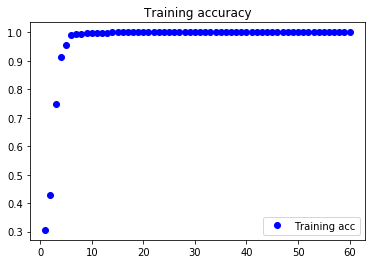

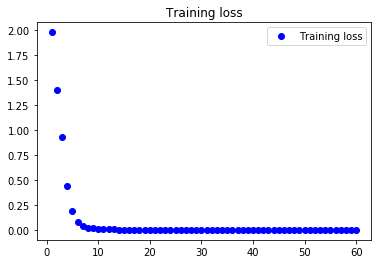

In [13]:
training_report(history)

In [14]:
#test the model on our testing data
def test_model(model, x_test):
    #gather the models prediction 
    
    #the model displays its prediction as a percent for every bucket at how confident the model is for 
    #each bucket. 
    
    #the highest percent in our case the the bucket the model has choosen
    preds = model.predict(x_test)
    
    y_pred = []
    
    #for ever row in the prediction list
    #grab the max value and append that index to the y_pred
    for row in preds:
        y_pred.append(np.argmax(row))
    
    #convert the list to a numpy array
    return np.asarray(y_pred)

In [15]:
#create the confusion matrix
def test_confusion_matrix(y_pred,y_test):
    return confusion_matrix(y_test, y_pred)

In [16]:
#create the classification report
def test_classification_report(y_pred,y_test):
    print(classification_report(y_test, y_pred))

In [17]:
#grab all params and bucketname from bucket1Items
#this is a large test set of 25000 examples
query ="select test.subSpecialtyCd, test.fillerOrderStatusCd, test.locationName, test.scheduledGroups, CASE WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') = '*GYP' AND test.locationName LIKE '%SPOKANE%' AND test.scheduledGroups = '1' AND test.fillerOrderStatusCd LIKE '%F%' THEN 1 WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') NOT LIKE '*GYP' AND test.locationName LIKE '%SPOKANE%' AND test.scheduledGroups = '3' THEN 2 WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND test.locationName LIKE '%SPOKANE%' THEN 3 WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') LIKE '*GP' AND test.locationName LIKE '%BELLEVUE%' AND test.scheduledGroups = '3' AND test.fillerOrderStatusCd LIKE '%F%' THEN 4 WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND test.locationName LIKE '%BELLEVUE%' AND test.scheduledGroups = '1' AND test.fillerOrderStatusCd LIKE '%C%' THEN 5 WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND test.locationName LIKE '%BELLEVUE%' AND test.scheduledGroups = '1' AND test.fillerOrderStatusCd LIKE '%F%' THEN 6 WHEN test.locationName LIKE '%BELLEVUE%' THEN 7 WHEN test.locationName LIKE '%SPOKANE%' THEN 8 WHEN test.scheduledGroups = '1' THEN 9 WHEN test.scheduledGroups = '2' OR test.scheduledGroups = '3' OR test.scheduledGroups = '4' THEN 10 WHEN test.scheduledGroups = '5' OR test.scheduledGroups = '6' OR test.scheduledGroups = '7' OR test.scheduledGroups = '8' THEN 11 ELSE 12 END as bucketName from ( SELECT ISNULL( ProcedureStep.subSpecialtyCd, 'UNKNOWN' ) AS subSpecialtyCd, ISNULL( FillerOrder.fillerOrderStatusCd, 'UNKNOWN' ) as fillerOrderStatusCd, ISNULL(PL.locationName, 'UNKNOWN') as locationName, case when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 465 then 1 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 562 then 2 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 664 then 3 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 762 then 4 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 860 then 5 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 955 then 6 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 1056 then 7 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 1153 then 8 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 1247 then 9 else 10 end as scheduledGroups FROM ProcedureStep LEFT JOIN RequestedProcedure ON ProcedureStep.requestedProcedureKey = RequestedProcedure.requestedProcedureKey LEFT JOIN FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey ) as test"
original1 = getData(server, UID, PWD, database,query)
data1 = original1.copy()

In [18]:
data1 = original1.copy()

In [19]:
#display the data before preprocessing

data1

,subSpecialtyCd,fillerOrderStatusCd,locationName,scheduledGroups,bucketName
0,*GYP,S,UNKNOWN,10,12
1,*DP,S,UNKNOWN,10,12
2,UNKNOWN,S,UNKNOWN,10,12
3,UNKNOWN,F,UNKNOWN,10,12
4,UNKNOWN,S,UNKNOWN,10,12
5,UNKNOWN,F,UNKNOWN,10,12
6,UNKNOWN,S,UNKNOWN,10,12
7,UNKNOWN,F,UNKNOWN,10,12
8,UNKNOWN,F,UNKNOWN,10,12
9,UNKNOWN,F,UNKNOWN,10,12


In [20]:
#this is where we preprocess the model
#we want to map all the params to the same integer as we trained on

#for example subspecialty *gp is at index 5 of our distinct list of all subspecialties
#during training *gp was associated with intger number 5, so we need to keep that consistent for testing.

data1['subSpecialtyCd'] = data1.subSpecialtyCd.apply(lambda x: np.where(subSpecialtyCd.values == x)[0][0])
data1['fillerOrderStatusCd'] = data1.fillerOrderStatusCd.apply(lambda x: np.where(fillerOrderStatusCd.values == x)[0][0])
data1['locationName'] = data1.locationName.apply(lambda x: np.where(locationNameCd.values == x)[0][0])
data1['scheduledGroups'] = data1.scheduledGroups.apply(lambda x: np.where(scheduledGroups == x)[0][0])

data1['bucketName'] = data1.bucketName.apply(lambda x: np.where(bucketNumCd == x)[0][0])

In [21]:
#display the "vectorized" training data
data1

,subSpecialtyCd,fillerOrderStatusCd,locationName,scheduledGroups,bucketName
0,7,7,9,9,11
1,2,7,9,9,11
2,18,7,9,9,11
3,18,3,9,9,11
4,18,7,9,9,11
5,18,3,9,9,11
6,18,7,9,9,11
7,18,3,9,9,11
8,18,3,9,9,11
9,18,3,9,9,11


In [22]:
#create the test input set based on the three params
x_test = data1[['subSpecialtyCd', 'fillerOrderStatusCd', 'locationName', 'scheduledGroups' ]]

#create the test labels set
y_test = data1[['bucketName']]

In [23]:
#test the model against our test data and store the predictions in Y_pred
Y_pred = test_model(model, x_test)

In [24]:
#display the confusion matrix on the predictions
holder = test_confusion_matrix(Y_pred,y_test)
matrix = pd.DataFrame(holder)
matrix

,0,1,2,3,4,5,6,7,8,9,10,11
0,11991,0,0,0,0,0,0,0,0,0,0,0
1,0,15786,0,0,0,0,0,0,0,0,0,0
2,0,0,39761,0,0,0,0,0,0,0,0,0
3,0,0,0,4676,0,0,0,0,0,0,0,0
4,0,0,0,0,12,0,0,0,0,0,0,0
5,0,0,0,0,0,9650,0,0,0,0,0,0
6,0,0,0,0,0,0,60682,0,0,0,0,0
7,0,0,0,0,0,0,0,43563,0,0,0,0
8,0,0,0,0,0,0,0,0,41211,0,0,0
9,0,0,0,0,0,0,0,0,0,139419,0,0


In [25]:
#display the classification report on the predictions
test_classification_report(Y_pred, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11991
           1       1.00      1.00      1.00     15786
           2       1.00      1.00      1.00     39761
           3       1.00      1.00      1.00      4676
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00      9650
           6       1.00      1.00      1.00     60682
           7       1.00      1.00      1.00     43563
           8       1.00      1.00      1.00     41211
           9       1.00      1.00      1.00    139419
          10       1.00      1.00      1.00    367956
          11       1.00      1.00      1.00    187290

    accuracy                           1.00    921997
   macro avg       1.00      1.00      1.00    921997
weighted avg       1.00      1.00      1.00    921997



In [26]:
#here we convert from an integer or "vectorized" form of data 
#back to its corresponding string value

#for all subspecialty integers in data1, map the integer back to the corresponding string value
#in our distinct list called subSpecialtyCd

#for example. subspecialty 5 is the index value to *gp, so map index 5 back to *gp

data1['subSpecialtyCd'] = data1.subSpecialtyCd.apply(lambda x: subSpecialtyCd.values.item(x))
data1['fillerOrderStatusCd'] = data1.fillerOrderStatusCd.apply(lambda x: fillerOrderStatusCd.values.item(x))
data1['locationName'] = data1.locationName.apply(lambda x: locationNameCd.values.item(x))
data1['scheduledGroups'] = data1.scheduledGroups.apply(lambda x: scheduledGroups.item(x))
data1['bucketName'] = data1.bucketName.apply(lambda x: bucketNumCd.item(x))

#now we want to add the predicted bucket Name to our data1 for comparison.
data1['predBucketName'] = pd.DataFrame(Y_pred)

#since we have not mapped back the index value of the bucketNum to the string value of the bucketName
#we can simpley do that by ...
#for every prediction we grab the item at the corresponding index from bucketNumCd


data1['predBucketName'] = data1.predBucketName.apply(lambda x: bucketNumCd.item(x))

In [27]:
#display the "un-vectorized" testing data along with the predicted bucket
data1

,subSpecialtyCd,fillerOrderStatusCd,locationName,scheduledGroups,bucketName,predBucketName
0,*GYP,S,UNKNOWN,10,12,12
1,*DP,S,UNKNOWN,10,12,12
2,UNKNOWN,S,UNKNOWN,10,12,12
3,UNKNOWN,F,UNKNOWN,10,12,12
4,UNKNOWN,S,UNKNOWN,10,12,12
5,UNKNOWN,F,UNKNOWN,10,12,12
6,UNKNOWN,S,UNKNOWN,10,12,12
7,UNKNOWN,F,UNKNOWN,10,12,12
8,UNKNOWN,F,UNKNOWN,10,12,12
9,UNKNOWN,F,UNKNOWN,10,12,12


In [28]:
#use sql against our data2 pandas dataframe to select all 
#instances where the model incorrectly predicted the bucketName
#this is the querry
q1 = """SELECT * FROM data1 where predBucketName not like bucketName"""

#use pandasql main function sqldf
#accepts two parameters.. 1 the querry, 2 the variables
#here we specify locals as our variables
#store and display the result as a pandas dataframe
pd.DataFrame(ps.sqldf(q1, locals()))


,subSpecialtyCd,fillerOrderStatusCd,locationName,scheduledGroups,bucketName,predBucketName
